<a href="https://colab.research.google.com/github/uhdang/mlim_group_3_final_assignment/blob/main/master_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ToDo

- add feature if coupon was given for complementary category
- Exercise #7 - slide 5
- own-product moving window purchase frequencies
- own-category moving window purchase frequencies
- customer embedding (matrix-factorization)
- negative sampling instead of using all products for each shopper
- Crossvalidation
- PCA for product vectors included as feature and then remove product
- price elasticity (own and cross product/category)
- promotion in substitute or complementary category

Put code in functions or maybe classes

In [1]:
# !pip install scikit-learn --upgrade
# !pip install lightgbm --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load Data

In [3]:
# Colab from google.colab import drive  drive.mount('/content/drive'
  baskets = pd.read_parquet("/content/drive/MyDrive/My Drive/baskets.parquet
  coupons = pd.read_parquet("/content/drive/MyDrive/My Drive/coupons.parque)
  coupon_index = pd.read_parquet("/content/drive/MyDrive/My Drive/coupon_index.parqdf: {ci_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Jupyter Lab
file_path = "../data/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
coupon_index_pq = "coupon_index.parquet"

baskets = pd.read_parquet(file_path + baskets_pq)
coupons = pd.read_parquet(file_path + coupons_pq)
coupon_index = pd.read_parquet(file_path + coupon_index_pq)

print(f"baskets_df: {baskets.shape}")
print(f"coupons_df: {coupons.shape}")
print(f"coupon_index_df: {coupon_index.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
coupon_index_df: (10000, 3)


In [4]:
baskets['target'] = 1

# Split Data

In [5]:
weeks = 89 
shoppers = 100

baskets_train = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week<weeks), :]
baskets_test = baskets.loc[(baskets.shopper.isin(list(range(shoppers)))) & (baskets.week>=weeks), :]

coupons_train = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week<weeks), :]
coupons_test = coupons.loc[(coupons.shopper.isin(list(range(shoppers)))) & (coupons.week>=weeks), :]

In [6]:
cat_columns = ['shopper', 'product']

baskets_train[cat_columns] = baskets_train[cat_columns].astype('category')
baskets_test[cat_columns] = baskets_test[cat_columns].astype('category')
coupons_train[cat_columns] = coupons_train[cat_columns].astype('category')
coupons_test[cat_columns] = coupons_test[cat_columns].astype('category')

baskets[cat_columns] = baskets[cat_columns].astype('category')
coupons[cat_columns] = coupons[cat_columns].astype('category')

/Users/jungwoojamesjeong/opt/anaconda3/envs/hu-bads/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Product2Vec

## Step 1
Create a list of baskets.

In [7]:
# create a list of baskets
shoppers_p2v = 1000
baskets_p2v = baskets.loc[(baskets.shopper.isin(list(range(shoppers_p2v)))) & (baskets.week<weeks), :][['week', 'shopper', 'product']]

basket_values = baskets_p2v.sort_values(['week', 'shopper']).values
keys = baskets_p2v.week.astype(str) + '_' + baskets_p2v.shopper.astype(str)
_, index = np.unique(keys, True)
basket_arr = np.split(basket_values[:, 2].astype('str'), np.sort(index))[1:]

In [8]:
# streamer class to fill word2vec list by list
class DataStreamer():
    def __init__(self, data):
        self.data = data
        
    def __iter__(self):
        for basket in self.data:
            yield basket.tolist()

## Step 2


In [9]:
from gensim.models import Word2Vec

In [10]:
datastr = DataStreamer(basket_arr)

model = Word2Vec(
    sentences=datastr, 
    size=100, 
    window=20, # max. size of basket 
    min_count=1,
    negative=2, 
    sample=0,
    sg=1,
    workers=4
)

In [11]:
model.wv.most_similar(positive='76')

[('71', 0.5913386344909668),
 ('74', 0.5517319440841675),
 ('78', 0.545609176158905),
 ('72', 0.5402967929840088),
 ('79', 0.5398701429367065),
 ('75', 0.49135079979896545),
 ('73', 0.4848102927207947),
 ('77', 0.4053838551044464),
 ('70', 0.3556126356124878),
 ('112', 0.23727774620056152)]

In [12]:
product_keys = [str(product) for product in range(250)]
product_vectors = model.wv[product_keys]

## Step 3: Assigning Categories

### Substitutes | Similar Products

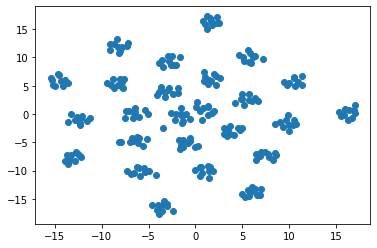

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(product_vectors)
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(product_vectors)
kmeans.labels_

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8, 20, 20, 20, 20,  9, 20, 20, 20,
       20,  9, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  1,
        1,  1,  1,  1,  1

In [15]:
# Generate a product category
products = [product for product in range(250)]
prods_cat_table = pd.DataFrame(data=products, columns=["product"])
prods_cat_table["category"] = kmeans.labels_
prods_cat_table[['product', 'category']] = prods_cat_table[['product', 'category']].astype('category')

In [16]:
prods_cat_table.head()

,product,category
0,0,22
1,1,22
2,2,22
3,3,22
4,4,22


### Complementary Products

In Progress

In [17]:
# w_in
w_in = model.wv.vectors

# w_out
w_out = model.trainables.syn1neg

In [18]:
w_in.shape

(250, 100)

In [19]:
np.dot(w_in[0], w_out[0])

-3.6445107

In [20]:
np.argmax([np.dot(w_in[0], context) for context in w_out])

29

In [21]:
model.wv.most_similar('105')

[('101', 0.5841051340103149),
 ('106', 0.5389761924743652),
 ('102', 0.4900280237197876),
 ('100', 0.4862634539604187),
 ('104', 0.4754922389984131),
 ('107', 0.4693756103515625),
 ('108', 0.44804662466049194),
 ('103', 0.4307035505771637),
 ('109', 0.4113791286945343),
 ('125', 0.27912795543670654)]

In [22]:
model.wv.vocab['105'].index

0

In [23]:
model.wv.vocab['138'].index

39

In [24]:
model.wv.index2word[26]

'202'

In [25]:
model.predict_output_word(['3'])

[('197', 0.019428186),
 ('138', 0.018522443),
 ('79', 0.018301914),
 ('222', 0.017487105),
 ('105', 0.01658476),
 ('126', 0.015702095),
 ('48', 0.014365487),
 ('62', 0.0139852585),
 ('249', 0.012956566),
 ('17', 0.012712247)]

## Merge with baskets and coupons

In [26]:
baskets_train = baskets_train.merge(prods_cat_table, on=['product'], how='left')
baskets_test = baskets_test.merge(prods_cat_table, on=['product'], how='left')

coupons_train = coupons_train.merge(prods_cat_table, on=['product'], how='left')
coupons_test = coupons_test.merge(prods_cat_table, on=['product'], how='left')

In [27]:
# baskets_train.head()

# Feature Engineering

Product related features:

In [28]:
original_price = baskets.groupby('product', as_index=False).price.max().rename(columns={'price': 'original_price'})
total_count_of_product = baskets_train.groupby(['shopper', 'product']).product.count().to_frame('total_count_of_product').reset_index()
reordered_product = (baskets_train.groupby(['shopper']).product.value_counts()>1).astype(int)

# ratio probably don't needed, so leave it out 
# ratio_of_reordered_per_product = total_count_of_product.copy()
# ratio_of_reordered_per_product['total_count_of_product'] = total_count_of_product['total_count_of_product'] / (baskets_train.week.max()+1)
# ratio_of_reordered_per_product.rename(columns={'total_count_of_product': 'ratio_of_reordered_per_product'}, inplace=True)

Category related features:

In [29]:
category_count = baskets_train.groupby(['shopper', 'category']).category.count().to_frame('category_count').reset_index()
reordered_category = (baskets_train.groupby(['shopper']).category.value_counts()>1).astype(int)

coupon_in_same_category = coupons_train.loc[:, ['week', 'shopper', 'category']].drop_duplicates()
coupon_in_same_category['coupon_in_same_category'] = 'Yes'
# coupon_in_complementary_category =

# ratio_of_reordered_per_category = category_count.copy()
# ratio_of_reordered_per_category['category_count'] = category_count['category_count'] / (baskets_train.week.max()+1)
# ratio_of_reordered_per_category.rename(columns={'category_count': 'ratio_of_reordered_per_category'}, inplace=True)


Shopper related features:

In [30]:
average_price_per_shopper = baskets_train.groupby(['shopper']).price.mean().to_frame('average_price_per_shopper').reset_index()
average_basket_size = baskets_train.groupby(['shopper', 'week']).product.count().groupby('shopper').mean().to_frame('average_basket_size').reset_index()
unique_products_per_shopper = baskets_train.groupby(['shopper']).product.nunique()
unique_categories_per_shopper = baskets_train.groupby(['shopper']).category.nunique()
ratio_of_reordered_products_per_shopper = (reordered_product.groupby('shopper').sum() / unique_products_per_shopper).to_frame('ratio_of_reordered_products').reset_index()
ratio_of_reordered_categories_per_shopper = (reordered_category.groupby('shopper').sum() / unique_categories_per_shopper).to_frame('ratio_of_reordered_categories').reset_index()

# window-average -> feature which give less probability to products wich haven't been purchased for a long time -> maybe relates to category as shopper has changed to product in similar category
# add average week interval for each product and shopper -> frequency | maybe not necessary, basically just total_count/weeks, probably already covered by model
# WoE

Reframing:

In [31]:
reordered_product = reordered_product.to_frame('reordered_product').reset_index()
reordered_category = reordered_category.to_frame('reordered_category').reset_index()
unique_products_per_shopper = unique_products_per_shopper.to_frame('unique_products_per_shopper').reset_index()
unique_categories_per_shopper = unique_categories_per_shopper.to_frame('unique_categories_per_shopper').reset_index()

# Set Up Training Table

In [32]:
full_df_train = (baskets_train
                 .merge(
                     coupons_train, 
                     on=['week', 'shopper', 'product', 'category'], 
                     how='outer',
                     indicator=True
                 )
                 .sort_values(by=['week', 'shopper', 'product'])
                 .reset_index(drop=True)
                 .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
                 .rename(columns={'_merge': 'coupon'})
)

full_df_train['discount'].fillna(0, inplace=True)

In [33]:
df1 = pd.DataFrame({'key':np.ones(weeks), 'week':list(range(weeks))})
df2 = pd.DataFrame({'key':np.ones(shoppers), 'shopper':list(range(shoppers))})
df3 = pd.DataFrame({'key':np.ones(250), 'product':list(range(250))})

X_train = (pd
           .merge(df1, df2, on='key')
           .merge(df3, on='key')
           .merge(prods_cat_table, on='product')
           .merge(full_df_train, on=['week', 'shopper', 'product', 'category'], how='left')[full_df_train.columns]
)

In [34]:
X_train

,week,shopper,product,price,target,category,discount,coupon
0,0,0,0,NaN,NaN,22,NaN,NaN
1,0,1,0,NaN,NaN,22,NaN,NaN
2,0,2,0,NaN,NaN,22,NaN,NaN
3,0,3,0,NaN,NaN,22,NaN,NaN
4,0,4,0,NaN,NaN,22,NaN,NaN
...,...,...,...,...,...,...,...,...
2224995,88,95,249,NaN,NaN,2,NaN,NaN
2224996,88,96,249,NaN,NaN,2,NaN,NaN
2224997,88,97,249,NaN,NaN,2,NaN,NaN
2224998,88,98,249,499.0,1.0,2,0.0,No


Combine all features

In [81]:
X_train = (X_train
           .merge(original_price, on=['product'], how='left')
           .merge(total_count_of_product, on=['shopper', 'product'], how='left')
           .merge(reordered_product, on=['shopper', 'product'], how='left')
          #  .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
           .merge(category_count, on=['shopper', 'category'], how='left')
           .merge(reordered_category, on=['shopper', 'category'], how='left')
           .merge(coupon_in_same_category, on=['week', 'shopper', 'category'], how='left')
           .merge(ratio_of_reordered_products_per_shopper, on=['shopper'], how='left')
           .merge(ratio_of_reordered_categories_per_shopper, on=['shopper'], how='left')
           .merge(average_price_per_shopper, on=['shopper'], how='left')
           .merge(average_basket_size, on=['shopper'], how='left')
           .merge(unique_products_per_shopper, on=['shopper'], how='left')
           .merge(unique_categories_per_shopper, on=['shopper'], how='left')
           )

In [82]:
X_train.head()

,week,shopper,product,price,target,category,discount,coupon,original_price,total_count_of_product,reordered_product,category_count,reordered_category,coupon_in_same_category,ratio_of_reordered_products,ratio_of_reordered_categories,average_price_per_shopper,average_basket_size,unique_products_per_shopper,unique_categories_per_shopper
0,0,0,0,NaN,NaN,23,NaN,NaN,688,0,NaN,8,1.0,Yes,0.722222,0.960000,587.203947,8.539326,54,25
1,0,1,0,NaN,NaN,23,NaN,NaN,688,6,1.0,28,1.0,Yes,0.830986,1.000000,584.065350,7.393258,71,24
2,0,2,0,NaN,NaN,23,NaN,NaN,688,0,NaN,53,1.0,NaN,0.700000,0.954545,571.918919,5.820225,60,22
3,0,3,0,NaN,NaN,23,NaN,NaN,688,0,NaN,37,1.0,NaN,0.714286,1.000000,561.846361,8.337079,91,24
4,0,4,0,NaN,NaN,23,NaN,NaN,688,0,NaN,8,1.0,NaN,0.764706,1.000000,583.750455,6.168539,34,20


In [83]:
X_train.isna().any()

week                             False
shopper                          False
product                          False
price                             True
target                            True
category                         False
discount                          True
coupon                            True
original_price                   False
total_count_of_product           False
reordered_product                 True
category_count                   False
reordered_category                True
coupon_in_same_category           True
ratio_of_reordered_products      False
ratio_of_reordered_categories    False
average_price_per_shopper        False
average_basket_size              False
unique_products_per_shopper      False
unique_categories_per_shopper    False
dtype: bool

In [84]:
X_train['discount'].fillna(0, inplace=True)
X_train['price'].fillna(X_train.original_price*(1-X_train.discount/100), inplace=True)
X_train['reordered_product'].fillna(0, inplace=True)
X_train['reordered_category'].fillna(0, inplace=True)
X_train['coupon'].fillna('No', inplace=True)
X_train['target'].fillna(0, inplace=True)
X_train['coupon_in_same_category'].fillna('No', inplace=True)

In [85]:
# Count weeks since last order of that product
addkey = X_train.groupby(['shopper','product']).target.apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
X_train['weeks_since_prior_product_order'] = X_train.target.eq(0).groupby([X_train['shopper'], X_train['product'], addkey]).cumcount().add(1) # .cumsum()

# Count weeks since last order of that product
addkey = X_train.groupby(['shopper','category']).target.apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
X_train['weeks_since_prior_category_order'] = X_train.target.eq(0).groupby([X_train['shopper'], X_train['category'], addkey]).cumcount().add(1) # .cumsum()

In [86]:
X_train.head(3)

,week,shopper,product,price,target,category,discount,coupon,original_price,total_count_of_product,reordered_product,category_count,reordered_category,coupon_in_same_category,ratio_of_reordered_products,ratio_of_reordered_categories,average_price_per_shopper,average_basket_size,unique_products_per_shopper,unique_categories_per_shopper,weeks_since_prior_product_order,weeks_since_prior_category_order
0,0,0,0,688.0,0.0,23,0.0,No,688,0,0.0,8,1.0,Yes,0.722222,0.960000,587.203947,8.539326,54,25,1,1
1,0,1,0,688.0,0.0,23,0.0,No,688,6,1.0,28,1.0,Yes,0.830986,1.000000,584.065350,7.393258,71,24,1,1
2,0,2,0,688.0,0.0,23,0.0,No,688,0,0.0,53,1.0,No,0.700000,0.954545,571.918919,5.820225,60,22,1,1


In [87]:
X_train.drop('week', inplace=True, axis=1)
y_train = X_train.pop('target')

# Set Up Test Table

In [88]:
full_df_test = (baskets_test
                .merge(
                    coupons_test, 
                    on=['week', 'shopper', 'product', 'category'], 
                    how='outer',
                    indicator=True
                )
                .sort_values(by=['week', 'shopper', 'product'])
                .reset_index(drop=True)
                .replace(['left_only', 'right_only', 'both'], ['No', 'Yes', 'Yes'])
                .rename(columns={'_merge': 'coupon'})
)

full_df_test['discount'].fillna(0, inplace=True)

In [89]:
df1 = pd.DataFrame({'key': np.ones(len(baskets_test.week.unique())), 'week': baskets_test.week.unique()})
df2 = pd.DataFrame({'key': np.ones(shoppers), 'shopper': list(range(shoppers))})
df3 = pd.DataFrame({'key': np.ones(250), 'product': list(range(250))})

X_test = (pd
          .merge(df1, df2, on='key')
          .merge(df3, on='key')
          .merge(prods_cat_table, on='product')
          .merge(full_df_test, on=['week', 'shopper', 'product', 'category'], how='left')[full_df_test.columns]
)

In [90]:
X_test = (X_test
          .merge(original_price, on=['product'], how='left')
          .merge(total_count_of_product, on=['shopper', 'product'], how='left')
          .merge(reordered_product, on=['shopper', 'product'], how='left')
          #  .merge(ratio_of_reordered_per_product, on=['shopper', 'product'], how='left')
          .merge(category_count, on=['shopper', 'category'], how='left')
          .merge(reordered_category, on=['shopper', 'category'], how='left')
          .merge(coupon_in_same_category, on=['week', 'shopper', 'category'], how='left')
          .merge(ratio_of_reordered_products_per_shopper, on=['shopper'], how='left')
          .merge(ratio_of_reordered_categories_per_shopper, on=['shopper'], how='left')
          .merge(average_price_per_shopper, on=['shopper'], how='left')
          .merge(average_basket_size, on=['shopper'], how='left')
          .merge(unique_products_per_shopper, on=['shopper'], how='left')
          .merge(unique_categories_per_shopper, on=['shopper'], how='left')
)

In [91]:
X_test['discount'].fillna(0, inplace=True)
X_test['price'].fillna(X_test.original_price*(1-X_test.discount/100), inplace=True)
X_test['reordered_product'].fillna(0, inplace=True)
X_test['reordered_category'].fillna(0, inplace=True)
X_test['coupon'].fillna('No', inplace=True)
X_test['target'].fillna(0, inplace=True)
X_test['coupon_in_same_category'].fillna('No', inplace=True)

In [92]:
# Take weeks_since_prior_order from last available week in training and add 1
last_week_since_prior_product_order = X_train.groupby(['shopper', 'product']).weeks_since_prior_product_order.last() + 1
last_week_since_prior_category_order = X_train.groupby(['shopper', 'category']).weeks_since_prior_category_order.last() + 1

X_test = (X_test
          .merge(last_week_since_prior_product_order, on=['shopper', 'product'])
          .merge(last_week_since_prior_category_order, on=['shopper', 'category'])
)

In [93]:
X_test.drop('week', inplace=True, axis=1)
y_test = X_test.pop('target')

# One-Hot Encoding Products

LightGBM handles categorical data, so no separata encoding necessary

In [94]:
# from sklearn.preprocessing import OneHotEncoder

In [95]:
# enc = OneHotEncoder(sparse=False)

# encodings = X_train.select_dtypes(exclude=np.number).columns.tolist()
# # encoded = pd.DataFrame.sparse.from_spmatrix(enc.fit_transform(X_train[encodings]))
# encoded = pd.DataFrame(enc.fit_transform(X_train[encodings]))
# encoded.columns = enc.get_feature_names(encodings)

# X_train = pd.concat([X_train, encoded], axis=1).drop(encodings, axis=1)

# X_train = X_train.apply(pd.to_numeric)

# X_train.head(3)

# Training

In [96]:
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier

In [113]:
from collections import Counter

# count examples in each class
counter = Counter(y_train)
class_imbalance = counter[0] / counter[1] # parameter to counter class imbalance

lgb_clf = LGBMClassifier(
    scale_pos_weight=1 # =class_imbalance
    )

In [114]:
categorical = X_train.select_dtypes(exclude=np.number).columns.tolist()

for cats in categorical:
  X_train[cats] = X_train[cats].astype('category')
  X_test[cats] = X_test[cats].astype('category')

In [115]:
lgb_clf.fit(X_train, y_train, categorical_feature=categorical)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'coupon', 'coupon_in_same_category', 'product', 'shopper']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=31.749002811262713, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [116]:
lgb_clf.score(X_train, y_train)

0.8696188764044944

In [117]:
lgb_clf.score(X_test, y_test)

0.83204

## Evaluation

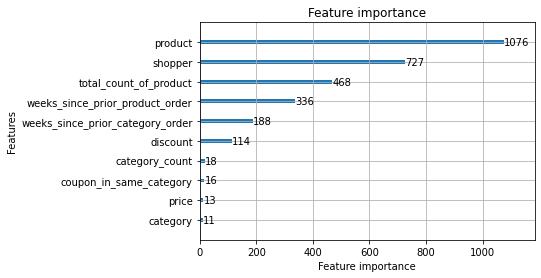

In [118]:
lgb.plot_importance(lgb_clf, max_num_features=10)

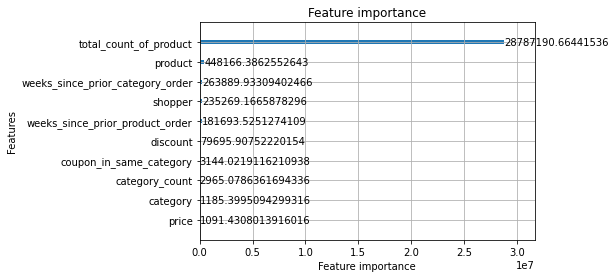

In [119]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

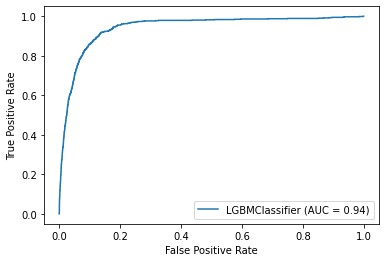

In [120]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(estimator=lgb_clf, X=X_test, y=y_test)

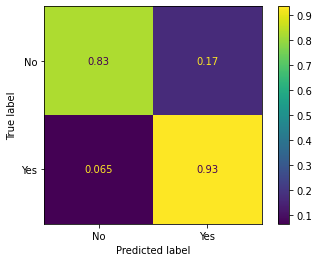

In [121]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [122]:
confusion

array([[20129,  4152],
       [   47,   672]])

In [123]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# Precision
PPV = TP/(TP+FP)
# False discovery rate -> 1-Precision
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [124]:
print(f'Precision: {PPV:.4f}')
print(f'Recall (TPR): {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')

Precision: 0.1393
Recall (TPR): 0.9346
TNR: 0.8290
FPR: 0.1710
FNR: 0.0654


## evaluating specific examples

In [109]:
pd.DataFrame(lgb_clf.predict_proba(X_test))

,0,1
0,0.999998,0.000002
1,0.999998,0.000002
2,0.999998,0.000002
3,0.999998,0.000002
4,0.896305,0.103695
...,...,...
24995,0.999998,0.000002
24996,0.506862,0.493138
24997,0.999998,0.000002
24998,0.999998,0.000002


In [125]:
pred_frame = pd.concat((X_test, y_test, pd.DataFrame(lgb_clf.predict_proba(X_test))[1]), axis=1)[['shopper', 'product', 'target', 'weeks_since_prior_product_order', 1]]

In [126]:
pred_frame.tail(10)

,shopper,product,target,weeks_since_prior_product_order,1
24990,99,240,0.0,90,0.000028
24991,99,241,0.0,90,0.000024
24992,99,242,0.0,44,0.519327
24993,99,243,0.0,90,0.000035
24994,99,244,0.0,90,0.000022
24995,99,245,0.0,90,0.000022
24996,99,246,1.0,12,0.962962
24997,99,247,0.0,90,0.000026
24998,99,248,0.0,90,0.000034
24999,99,249,0.0,90,0.000027


In [127]:
pred_frame.loc[(pred_frame['shopper']==0) & (pred_frame['product']==4)]

,shopper,product,target,weeks_since_prior_product_order,1
4,0,4,0.0,19,0.759463


In [128]:
X_train.loc[
            (X_train['shopper']==0) 
            & (X_train['product']==7)
]

,shopper,product,price,category,discount,coupon,original_price,total_count_of_product,reordered_product,category_count,reordered_category,coupon_in_same_category,ratio_of_reordered_products,ratio_of_reordered_categories,average_price_per_shopper,average_basket_size,unique_products_per_shopper,unique_categories_per_shopper,weeks_since_prior_product_order,weeks_since_prior_category_order
62300,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,Yes,0.722222,0.96,587.203947,8.539326,54,25,1,197
62400,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,Yes,0.722222,0.96,587.203947,8.539326,54,25,2,198
62500,0,7,540.4,23,30.0,Yes,772,0,0.0,8,1.0,Yes,0.722222,0.96,587.203947,8.539326,54,25,3,199
62600,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,No,0.722222,0.96,587.203947,8.539326,54,25,4,200
62700,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,No,0.722222,0.96,587.203947,8.539326,54,25,5,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70700,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,No,0.722222,0.96,587.203947,8.539326,54,25,85,281
70800,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,No,0.722222,0.96,587.203947,8.539326,54,25,86,282
70900,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,No,0.722222,0.96,587.203947,8.539326,54,25,87,283
71000,0,7,772.0,23,0.0,No,772,0,0.0,8,1.0,Yes,0.722222,0.96,587.203947,8.539326,54,25,88,284


In [ ]:
# from sklearn.inspection import plot_partial_dependence

# plot_partial_dependence(estimator=lgb_clf, X=X_test, features=['weeks_since_prior_order', 'discount']) -> only works with sklearn 0.24, so not working for google colab 

# Hypertuning

In [ ]:
# !sudo apt-get install build-essential swig
# !pip install auto-sklearn==0.12

## AutoML

In [ ]:
# import autosklearn.classification

In [ ]:
# from autosklearn.experimental.askl2 import AutoSklearn2Classifier

In [ ]:
# automl = AutoSklearn2Classifier(n_jobs=-1)
# automl.fit(X_train, y_train)

In [ ]:
# y_hat = automl.predict_proba(X_test)

In [73]:
# pred = [1 if prediction[1]>0.5 else 0 for prediction in y_hat ] 

In [74]:
# auto_confusion = confusion_matrix(y_test, pred) 

In [75]:
# auto_confusion

In [76]:
# FP = auto_confusion[0][1]
# FN = auto_confusion[1][0]
# TP = auto_confusion[1][1]
# TN = auto_confusion[0][0]

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # Precision
# PPV = TP/(TP+FP)
# # False discovery rate -> 1-Precision
# FDR = FP/(TP+FP)

# # Overall accuracy
# ACC = (TP+TN)/(TP+FP+FN+TN)

# print(f'TPR: {TPR:.4f}')
# print(f'TNR: {TNR:.4f}')
# print(f'FPR: {FPR:.4f}')
# print(f'FNR: {FNR:.4f}')
# print(f'Precision: {PPV:.4f}')
# print(f'False discovery rate: {FDR:.4f}')

In [77]:
# !pip install --quiet optuna

# import optuna

In [78]:
# clf = LGBMClassifier()

# param_distributions = {
#     'n_estimators': optuna.distributions.IntUniformDistribution(10, 500),
#     'num_leaves': optuna.distributions.IntUniformDistribution(2, 50),
#     'min_data_in_leaf': optuna.distributions.IntUniformDistribution(100, 400),
#     'feature_fraction': optuna.distributions.LogUniformDistribution(0.5, 1),
# #     'max_depth': optuna.distributions.IntUniformDistribution(-1, 200),
#     'subsample': optuna.distributions.LogUniformDistribution(0.5, 1),
# }

# optuna_search = optuna.integration.OptunaSearchCV(
#     estimator=clf, 
#     param_distributions=param_distributions, 
#     n_trials=50, 
#     timeout=7200,
#     cv=
# )

# optuna_search.fit(X_train, y_train)